# Milestone 1:  Circuit and Simulation in SNAP

### Setup


In [1]:
import getpass
import logging
from pathlib import Path
from itertools import chain

from bluepysnap.api import Api

logging.basicConfig(level=logging.WARNING)

ORGANIZATION = "nse"
PROJECT = "test"

Paste the token from https://bbp.epfl.ch/nexus/web/

In [2]:
TOKEN = getpass.getpass()

 ·······································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

In [3]:
api = Api(bucket=f"{ORGANIZATION}/{PROJECT}", token=TOKEN, debug=False)

### Instantiate a SNAP circuit from a KG URL

The following example illustrates how easy it is to retrieve circuit data from Nexus.

In [4]:
circuit_id = "https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/20191025"
circuit = api.get_entity_by_id(circuit_id)
print(circuit.type, circuit.id)
print(circuit)

DetailedCircuit https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/20191025
Entity(resource_id=<https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/20191025>, resource_type=<DetailedCircuit>, instance_type=<Proxy>)


In [5]:
print(circuit.resource)

{
    context: https://bbp.neuroshapes.org
    id: https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/20191025
    type: DetailedCircuit
    brainLocation:
    {
        brainRegion:
        {
            id: http://api.brain-map.org/api/v2/data/Structure/549
            label: Thalamus
        }
    }
    circuitBase:
    {
        type: DataDownload
        url: file:///gpfs/bbp.cscs.ch/project/proj82/circuits/Thalamus/20191025
    }
    circuitType: Atlas-based circuit
    description: First version of whole Thalamus model
    name: Whole Thalamus 2019.v1
    subject:
    {
        id: https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/a813ddf2-8031-4342-8da4-e27ccd0218fb
        type: Subject
    }
    wasGeneratedBy:
    {
        id: https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/eb41557b-22a6-4ee8-b76a-efb8fd7352b7
        type: WorkflowExecution
    }
}


### Get and print information about the circuit

In [6]:
circuit.description

'First version of whole Thalamus model'

In [7]:
region = circuit.brainLocation.brainRegion
print(region.id)
print(region.label)

http://api.brain-map.org/api/v2/data/Structure/549
Thalamus


In [8]:
species = getattr(circuit, 'species', None)
print(species)

None


In [9]:
print(circuit.project)

https://bbp.epfl.ch/nexus/v1/projects/nse/test


In [10]:
print(circuit.createdBy)
print(circuit.createdAt)

https://bbp.epfl.ch/nexus/v1/realms/bbp/users/ivaska
2019-12-19T10:09:20.630Z


### Illustrate bluepy/snap with a small piece of code

With `instance` you can open the circuit as a `bluepysnap.circuit.Circuit` instance and use it as you normally would.

In [11]:
print(circuit.instance)

In [12]:
from bluepysnap.bbp import Cell
from matplotlib import pyplot as plt

cells = circuit.instance.nodes.get(properties=[Cell.X, Cell.Y, Cell.Z])

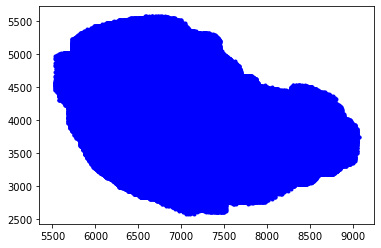

In [13]:
plt.plot(cells[Cell.X], cells[Cell.Y], ".b");

### Get Simulations that used that circuit

Changed after the initial version: the attribute `api._connector` is private because it's not meant to be accessed directly.

It's possible to call `api.get_entities` instead of `api._connector.get_resources`, that would return a list of `Entity` instead of a list of `Resource`.

In [14]:
# get simulations that used the circuit
sim1 = api.get_entities(
    "Simulation",
    {"used": {"id": circuit.id}}
)

# get simulation campaigns that used the circuit
simulation_campaigns = api.get_entities(
    "SimulationCampaign",
    {"used": {"id": circuit.id}}
)

# get simulations started by the simulation campaigns
ids = [r.id for r in simulation_campaigns]
sim2 = list(chain.from_iterable(api.get_entities(
    "Simulation",
    {"wasStartedBy": {"id": id_}} 
) for id_ in ids))  # Have to loop as "OR" is not supported by KnowledgeGraphForge.search.


# merge simulations and remove possible duplicates
simulations = {s.id: s for s in sim1 + sim2}
simulations = list(simulations.values())
print(len(sim1), len(sim2), len(simulations))

0 3 3


Alternatively, it's possible to execute a custom query:

In [15]:
query = f"""
    SELECT DISTINCT ?id
    WHERE {{
        {{
            ?id a Simulation ; wasStartedBy ?scid .
            ?scid a SimulationCampaign ; used <{circuit.id}> .
        }}
    UNION
        {{
            ?id a Simulation ; used <{circuit.id}> .
        }}
    }}
    """
simulations2 = api.get_entities_by_query(query)
sorted(entity.id for entity in simulations) == sorted(entity.id for entity in simulations2)

True

### Instantiate these simulation as BLUEPY entities either from the circuit or from a KG URL

The `open` method is called automatically when accessing `entity.instance`, that's a lazy proxy to the real instance depending on the library.

However, for Simulations, the current default tool is `bluepysnap`. To create entities that are opened with e.g., `bluepy`, we need to use the `reopen` function.

In [16]:
simulation_entities = [api.reopen(entity, "bluepy") for entity in simulations]

Another way to achieve is the same is to pass the `tool` parameter for the function fetching the entities (`get_entities`, `get_entities_by_id` or `get_entities_by_query`).

In [17]:
simulation_entities = api.get_entities_by_query(query, tool="bluepy")

### For each simulation display information about the simulation and Display a spike raster and psth
- Configuration of the simulation 
- Execution time / Creator
- KG Project it belongs to
- Description

### Simulation 0
Simulation path: /gpfs/bbp.cscs.ch/project/proj82/simulations/Thalamus/20191210/spontaneous_rest/TC2TC_W0p0/seed449150
createdAt: 2019-12-19T11:00:57.648Z
createdBy: https://bbp.epfl.ch/nexus/v1/realms/bbp/users/ivaska
project: https://bbp.epfl.ch/nexus/v1/projects/nse/test
description: duration=3000 target=Mosaic Ca=2.0


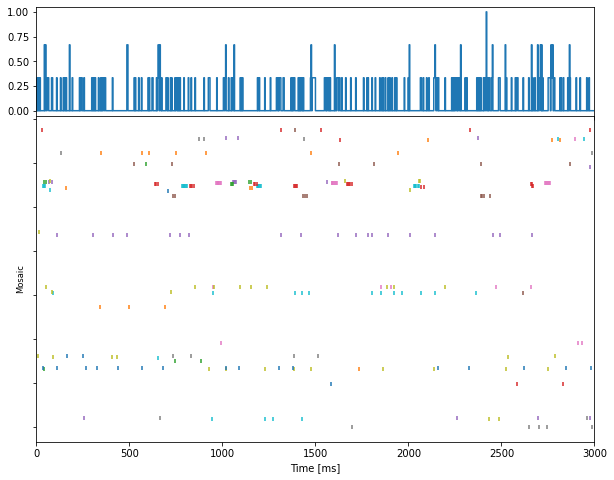

In [18]:
for n, sim in enumerate(simulation_entities):
    print(f"### Simulation {n}")
    print("Simulation path:", sim.path)
    print("createdAt:", sim.createdAt)
    print("createdBy:", sim.createdBy)
    print("project:", sim.project)
    print("description:", sim.description)
    sim.instance.plot.spikeraster_and_psth('soma', ['Mosaic'])
    break
